In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, adjusted_rand_score
import json
import os

plt.rcParams['figure.figsize'] = (14, 8)
np.random.seed(42)

In [ ]:
data = {}
for i in range(1, 4):
    df = pd.read_csv(f'data/S07-hw-dataset-0{i}.csv')
    print(f'\nDataset {i}:')
    print(f'  Shape: {df.shape}')
    print(f'  Head:\n{df.head()}')
    print(f'  Info:')
    df.info()
    print(f'  Describe:\n{df.describe()}')
    print(f'  Missing values:\n{df.isnull().sum()}')
    
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    # Исключаем sample_id из признаков - это идентификатор, не признак для кластеризации
    if 'sample_id' in numeric_cols:
        numeric_cols.remove('sample_id')
    
    data[f'ds{i}'] = {'df': df, 'numeric_cols': numeric_cols}
    print(f'  Numeric cols: {numeric_cols}')


Dataset 1:
  Shape: (12000, 9)
  Head:
   sample_id        f01        f02       f03         f04        f05  \
0          0  -0.536647 -69.812900 -0.002657   71.743147 -11.396498   
1          1  15.230731  52.727216 -1.273634 -104.123302  11.589643   
2          2  18.542693  77.317150 -1.321686 -111.946636  10.254346   
3          3 -12.538905 -41.709458  0.146474   16.322124   1.391137   
4          4  -6.903056  61.833444 -0.022466  -42.631335   3.107154   

         f06        f07       f08  
0 -12.291287  -6.836847 -0.504094  
1  34.316967 -49.468873  0.390356  
2  25.892951  44.595250  0.325893  
3   2.014316 -39.930582  0.139297  
4  -5.471054   7.001149  0.131213  
  Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  12000 non-null  int64  
 1   f01        12000 non-null  float64
 2   f02        12000 non-null  float64
 

: 

In [ ]:
preprocessed = {}

for ds_name, ds_data in data.items():
    df = ds_data['df']
    numeric_cols = ds_data['numeric_cols']
    
    sample_id = df['sample_id'] if 'sample_id' in df.columns else df.index
    X = df[numeric_cols].copy()
    
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    X_processed = pd.DataFrame(
        pipeline.fit_transform(X),
        columns=numeric_cols
    )
    
    preprocessed[ds_name] = {
        'X': X_processed,
        'sample_id': sample_id,
        'pipeline': pipeline
    }
    
    print(f'{ds_name}: processed {X_processed.shape}')

ds1: processed (12000, 8)
ds2: processed (8000, 3)
ds3: processed (15000, 4)


: 

In [ ]:
kmeans_results = {}

for ds_name, prep_data in preprocessed.items():
    X = prep_data['X']
    print(f'\n{ds_name} - KMeans:')
    
    k_range = range(2, 21)
    sil_scores = []
    db_scores = []
    models = []
    
    for k in k_range:
        km = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = km.fit_predict(X)
        sil = silhouette_score(X, labels)
        db = davies_bouldin_score(X, labels)
        
        sil_scores.append(sil)
        db_scores.append(db)
        models.append(km)
        print(f'  k={k:2d}: sil={sil:.4f}, db={db:.4f}')
    
    best_k_idx = np.argmax(sil_scores)
    best_k = list(k_range)[best_k_idx]
    
    kmeans_results[ds_name] = {
        'best_k': best_k,
        'best_model': models[best_k_idx],
        'sil_scores': sil_scores,
        'db_scores': db_scores,
        'k_range': list(k_range),
        'models': models
    }
    
    print(f'  Best k: {best_k}')


ds1 - KMeans:
  k= 2: sil=0.5216, db=0.6853
  k= 3: sil=0.3968, db=0.9646
  k= 4: sil=0.3833, db=1.1603
  k= 5: sil=0.3548, db=1.2737
  k= 6: sil=0.3586, db=1.1823
  k= 7: sil=0.3246, db=1.1942
  k= 8: sil=0.2689, db=1.3142
  k= 9: sil=0.2534, db=1.3440
  k=10: sil=0.2629, db=1.2770
  k=11: sil=0.2659, db=1.2141
  k=12: sil=0.2686, db=1.1563
  k=13: sil=0.2744, db=1.1412
  k=14: sil=0.2787, db=1.0869
  k=15: sil=0.2884, db=1.0409
  k=16: sil=0.2854, db=1.0385
  k=17: sil=0.2801, db=1.0481
  k=18: sil=0.2745, db=1.0566
  k=19: sil=0.2720, db=1.0614
  k=20: sil=0.2678, db=1.0632
  Best k: 2

ds2 - KMeans:
  k= 2: sil=0.3069, db=1.3235
  k= 3: sil=0.2700, db=1.2227
  k= 4: sil=0.2515, db=1.2998
  k= 5: sil=0.2521, db=1.2138
  k= 6: sil=0.2598, db=1.1595
  k= 7: sil=0.2536, db=1.1723
  k= 8: sil=0.2523, db=1.1002
  k= 9: sil=0.2525, db=1.0896
  k=10: sil=0.2609, db=1.0571
  k=11: sil=0.2659, db=1.0251
  k=12: sil=0.2636, db=1.0395
  k=13: sil=0.2654, db=1.0187
  k=14: sil=0.2719, db=0.992

: 

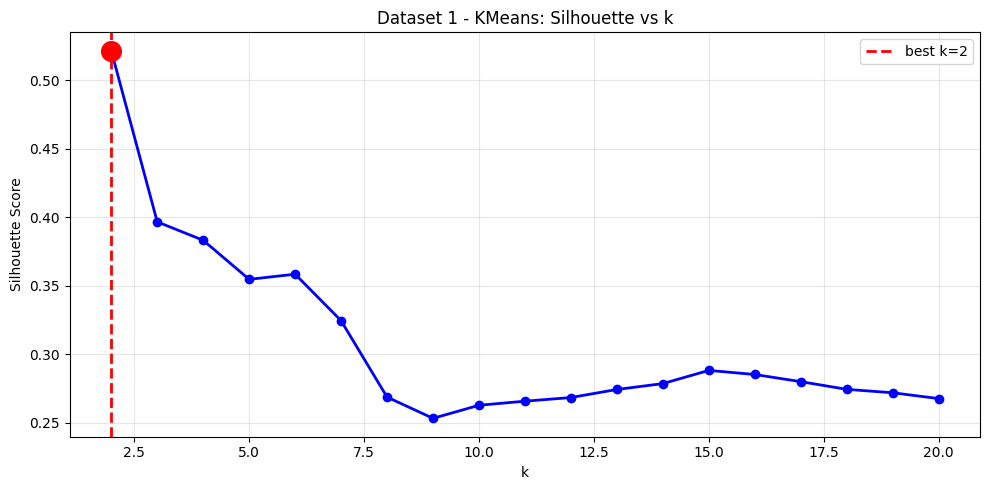

сохранено: kmeans_search_ds1.png


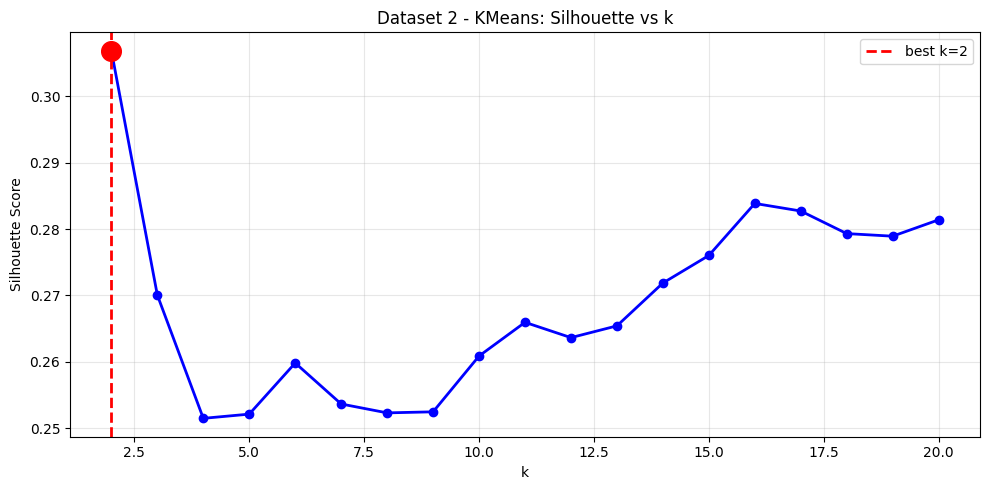

сохранено: kmeans_search_ds2.png


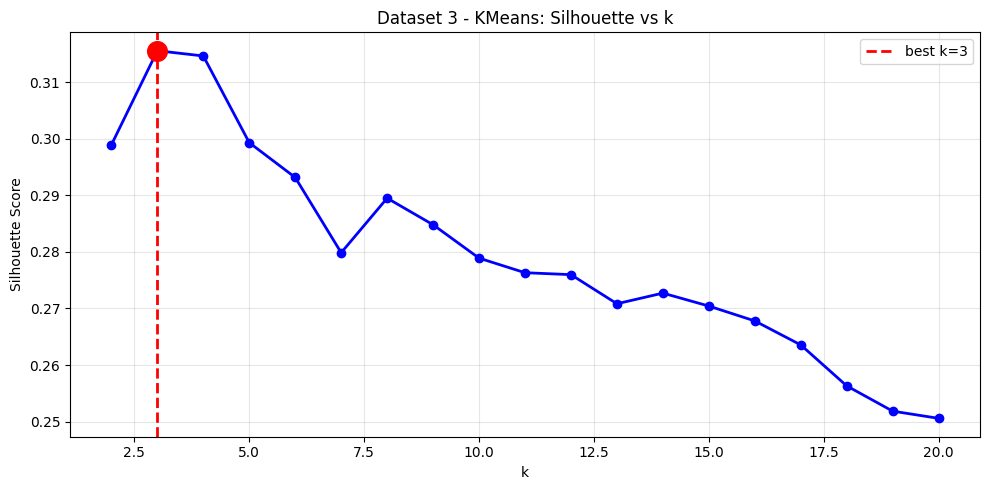

сохранено: kmeans_search_ds3.png


: 

In [ ]:
for idx, (ds_name, res) in enumerate(kmeans_results.items(), 1):
    fig, ax = plt.subplots(figsize=(10, 5))
    
    k_range = res['k_range']
    sil_scores = res['sil_scores']
    best_k = res['best_k']
    
    ax.plot(k_range, sil_scores, 'b-o', linewidth=2, markersize=6)
    ax.axvline(best_k, color='r', linestyle='--', linewidth=2, label=f'best k={best_k}')
    ax.scatter([best_k], [sil_scores[best_k-2]], color='r', s=200, zorder=5)
    
    ax.set_xlabel('k')
    ax.set_ylabel('Silhouette Score')
    ax.set_title(f'Dataset {idx} - KMeans: Silhouette vs k')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    plt.tight_layout()
    plt.savefig(f'artifacts/figures/kmeans_search_ds{idx}.png', dpi=100)
    plt.show()
    
    print(f'сохранено: kmeans_search_ds{idx}.png')

In [ ]:
dbscan_results = {}

for ds_name, prep_data in preprocessed.items():
    X = prep_data['X']
    print(f'\n{ds_name} - DBSCAN:')
    
    n_samples = X.shape[0]
    eps_range = np.linspace(0.2, 2.0, 10)
    min_samples_values = [3, 5, 10]
    
    best_sil = -1
    best_params = {}
    best_model = None
    all_results = []
    
    for min_samples in min_samples_values:
        for eps in eps_range:
            db = DBSCAN(eps=eps, min_samples=min_samples)
            labels = db.fit_predict(X)
            
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise = list(labels).count(-1)
            
            sil = -1
            if n_clusters > 0 and n_noise < len(X):
                try:
                    sil = silhouette_score(X, labels, sample_size=min(500, X.shape[0]))
                except:
                    sil = -1
            
            all_results.append({
                'eps': eps,
                'min_samples': min_samples,
                'n_clusters': n_clusters,
                'n_noise': n_noise,
                'sil': sil,
                'model': db
            })
            
            if sil > best_sil and n_clusters > 0:
                best_sil = sil
                best_params = {'eps': eps, 'min_samples': min_samples}
                best_model = db
    
    valid_results = [r for r in all_results if r['sil'] > 0]
    if valid_results:
        best_result = max(valid_results, key=lambda x: x['sil'])
    else:
        best_result = max(all_results, key=lambda x: x['n_clusters'])
    
    dbscan_results[ds_name] = {
        'best_params': {'eps': best_result['eps'], 'min_samples': best_result['min_samples']},
        'best_model': best_result['model'],
        'n_clusters': best_result['n_clusters'],
        'n_noise': best_result['n_noise'],
        'sil': best_result['sil'],
        'all_results': all_results
    }
    
    print(f'  Лучшие параметры: eps={best_result["eps"]:.2f}, min_samples={best_result["min_samples"]}')
    print(f'  Кластеры: {best_result["n_clusters"]}, Шум: {best_result["n_noise"]}')


ds1 - DBSCAN:
  Лучшие параметры: eps=1.80, min_samples=3
  Кластеры: 2, Шум: 0

ds2 - DBSCAN:
  Лучшие параметры: eps=0.80, min_samples=5
  Кластеры: 1, Шум: 44

ds3 - DBSCAN:
  Лучшие параметры: eps=0.80, min_samples=3
  Кластеры: 2, Шум: 22


: 

In [ ]:
metrics = {}

for ds_name, prep_data in preprocessed.items():
    X = prep_data['X']
    print(f'\n{ds_name} - Metrics:')
    
    km_model = kmeans_results[ds_name]['best_model']
    km_labels = km_model.fit_predict(X)
    
    km_sil = silhouette_score(X, km_labels)
    km_db = davies_bouldin_score(X, km_labels)
    km_ch = calinski_harabasz_score(X, km_labels)
    
    metrics[ds_name] = {
        'KMeans': {
            'silhouette': km_sil,
            'davies_bouldin': km_db,
            'calinski_harabasz': km_ch,
            'n_clusters': kmeans_results[ds_name]['best_k']
        }
    }
    
    print(f'  KMeans: sil={km_sil:.4f}, db={km_db:.4f}, ch={km_ch:.1f}')
    
    db_model = dbscan_results[ds_name]['best_model']
    db_labels = db_model.fit_predict(X)
    
    n_clusters_db = len(set(db_labels)) - (1 if -1 in db_labels else 0)
    n_noise = list(db_labels).count(-1)
    noise_ratio = n_noise / len(X)
    
    db_sil = -1
    db_db = -1
    db_ch = -1
    
    if n_clusters_db > 0:
        try:
            db_sil = silhouette_score(X, db_labels, sample_size=min(500, X.shape[0]))
            db_db = davies_bouldin_score(X, db_labels)
            db_ch = calinski_harabasz_score(X, db_labels)
        except:
            pass
    
    metrics[ds_name]['DBSCAN'] = {
        'silhouette': db_sil,
        'davies_bouldin': db_db,
        'calinski_harabasz': db_ch,
        'n_clusters': n_clusters_db,
        'noise_points': n_noise,
        'noise_ratio': noise_ratio
    }
    
    print(f'  DBSCAN: sil={db_sil:.4f}, db={db_db:.4f}, ch={db_ch:.1f}')
    print(f'  Noise: {n_noise} ({noise_ratio*100:.1f}%)')


ds1 - Metrics:
  KMeans: sil=0.5216, db=0.6853, ch=11787.0
  DBSCAN: sil=0.5223, db=0.6853, ch=11787.0
  Noise: 0 (0.0%)

ds2 - Metrics:
  KMeans: sil=0.3069, db=1.3235, ch=3573.4
  DBSCAN: sil=0.4810, db=7.6544, ch=7.6
  Noise: 44 (0.5%)

ds3 - Metrics:
  KMeans: sil=0.3155, db=1.1577, ch=6957.2
  DBSCAN: sil=-1.0000, db=-1.0000, ch=-1.0
  Noise: 22 (0.1%)


: 

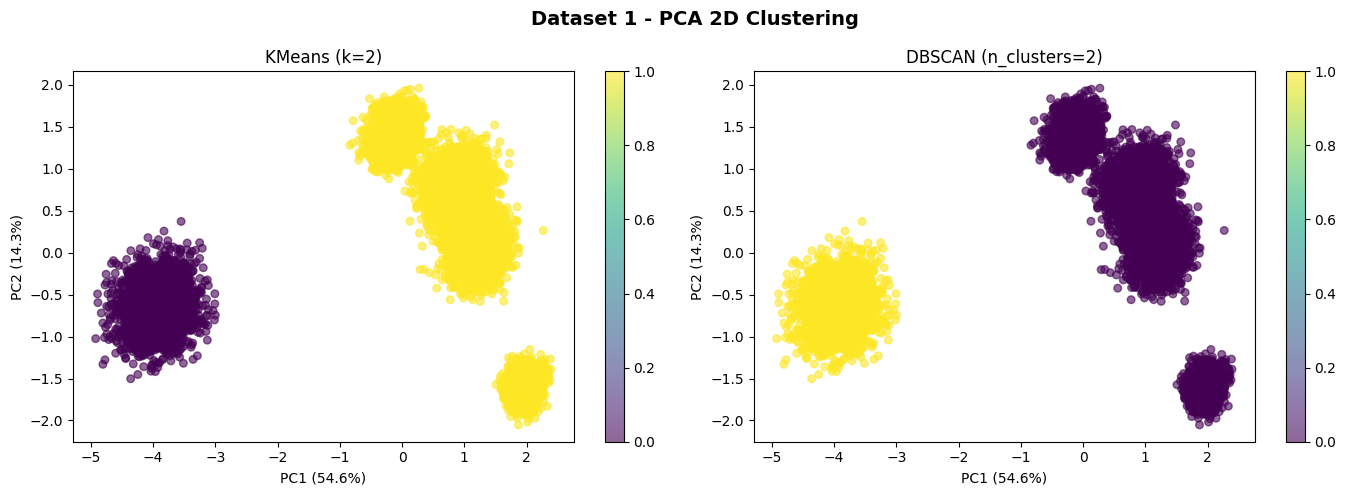

сохранено: pca_clustering_ds1.png


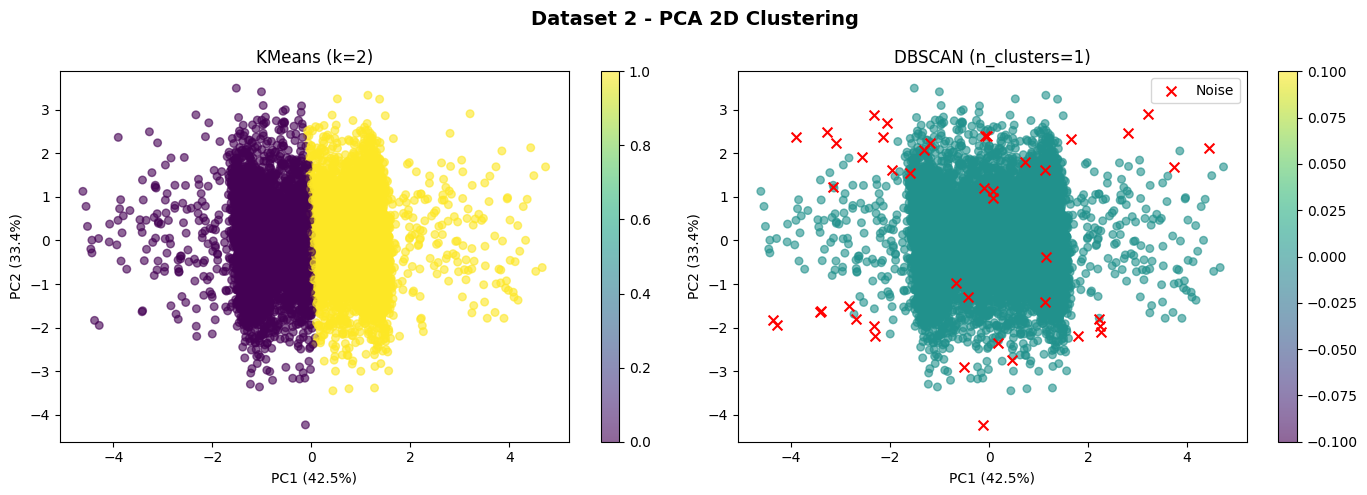

сохранено: pca_clustering_ds2.png


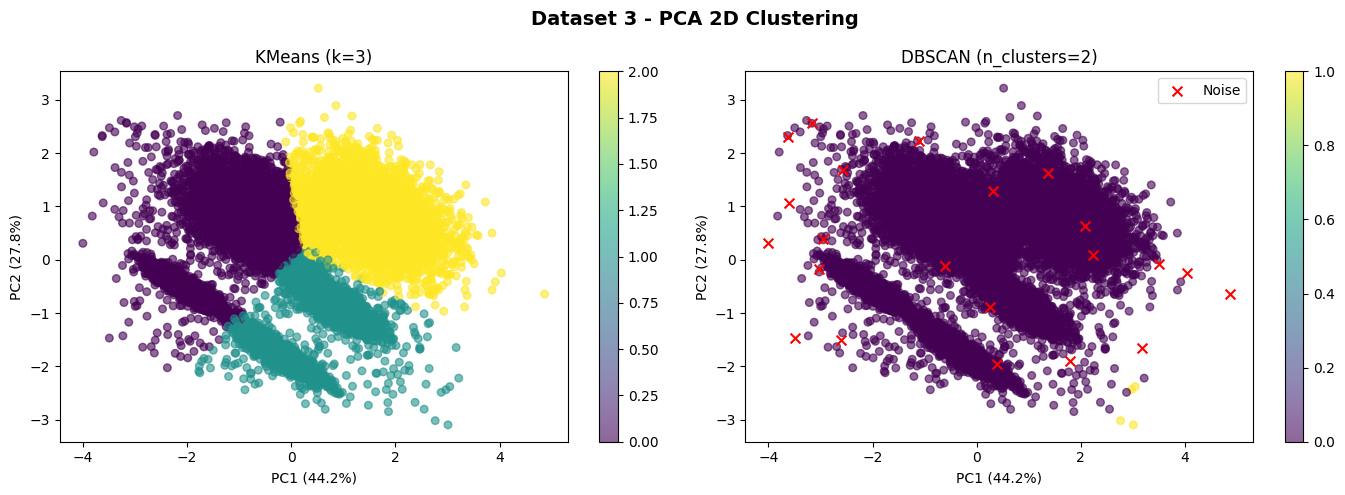

сохранено: pca_clustering_ds3.png


: 

In [ ]:
for idx, ds_name in enumerate(['ds1', 'ds2', 'ds3'], 1):
    X = preprocessed[ds_name]['X']
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle(f'Dataset {idx} - PCA 2D Clustering', fontsize=14, fontweight='bold')
    
    ax = axes[0]
    km_labels = kmeans_results[ds_name]['best_model'].predict(X)
    scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=km_labels, cmap='viridis', s=30, alpha=0.6)
    ax.set_title(f'KMeans (k={kmeans_results[ds_name]["best_k"]})')
    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
    plt.colorbar(scatter, ax=ax)
    
    ax = axes[1]
    db_labels = dbscan_results[ds_name]['best_model'].fit_predict(X)
    noise_mask = db_labels == -1
    
    scatter = ax.scatter(X_pca[~noise_mask, 0], X_pca[~noise_mask, 1], 
                        c=db_labels[~noise_mask], cmap='viridis', s=30, alpha=0.6)
    ax.scatter(X_pca[noise_mask, 0], X_pca[noise_mask, 1], 
              marker='x', c='red', s=50, label='Noise')
    
    ax.set_title(f'DBSCAN (n_clusters={dbscan_results[ds_name]["n_clusters"]})')
    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
    if noise_mask.sum() > 0:
        ax.legend()
    plt.colorbar(scatter, ax=ax)
    
    plt.tight_layout()
    plt.savefig(f'artifacts/figures/pca_clustering_ds{idx}.png', dpi=100)
    plt.show()
    
    print(f'сохранено: pca_clustering_ds{idx}.png')

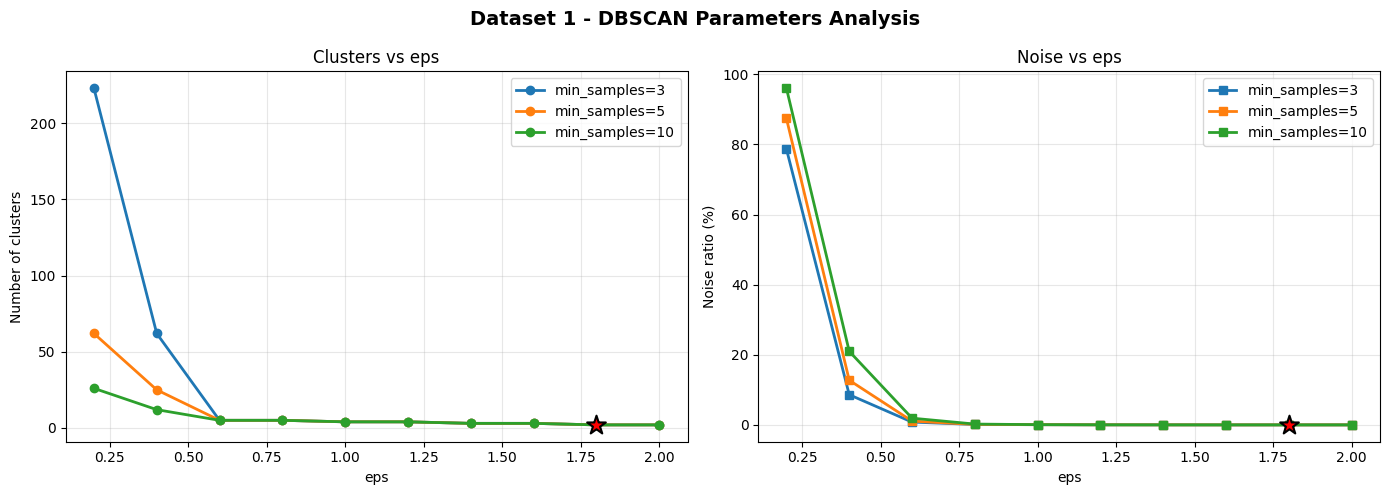

сохранено: dbscan_search_ds1.png


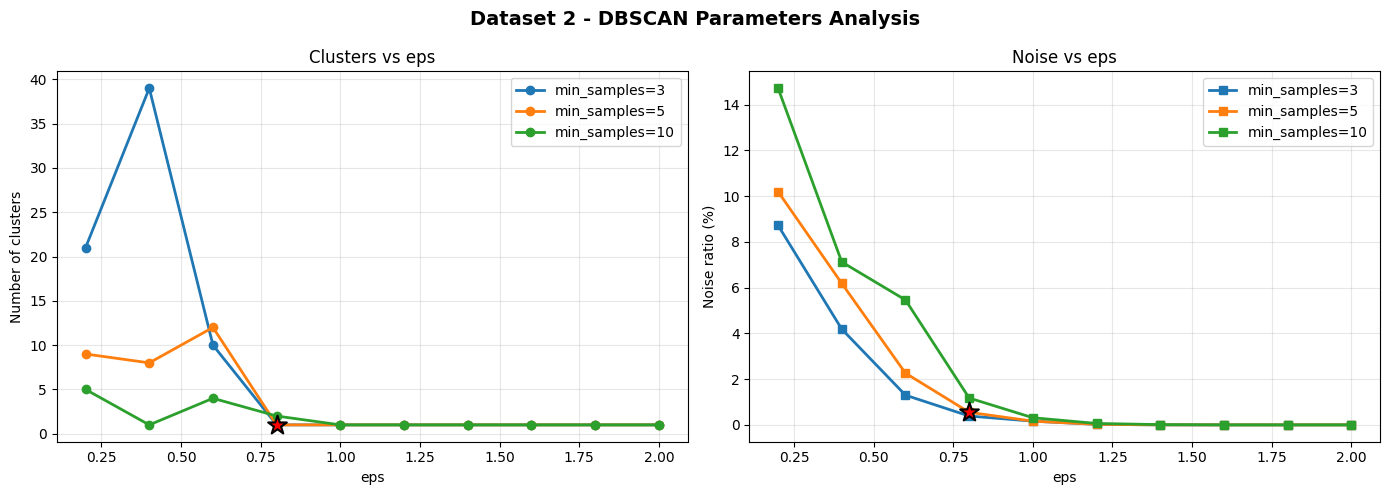

сохранено: dbscan_search_ds2.png


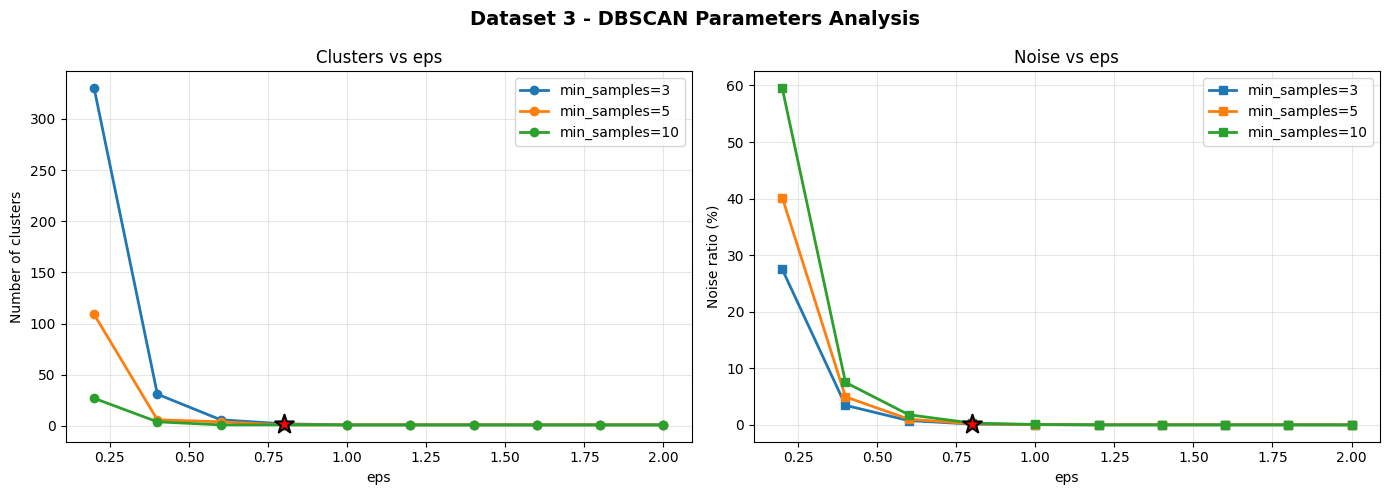

сохранено: dbscan_search_ds3.png


: 

In [ ]:
for idx, ds_name in enumerate(['ds1', 'ds2', 'ds3'], 1):
    all_results = dbscan_results[ds_name]['all_results']
    best_eps = dbscan_results[ds_name]['best_params']['eps']
    best_min_samples = dbscan_results[ds_name]['best_params']['min_samples']
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle(f'Dataset {idx} - DBSCAN Parameters Analysis', fontsize=14, fontweight='bold')
    
    eps_vals = sorted(set(r['eps'] for r in all_results))
    
    ax = axes[0]
    for min_samples in [3, 5, 10]:
        results = [r for r in all_results if r['min_samples'] == min_samples]
        eps_plot = [r['eps'] for r in results]
        n_clusters = [r['n_clusters'] for r in results]
        ax.plot(eps_plot, n_clusters, 'o-', label=f'min_samples={min_samples}', linewidth=2)
    
    ax.scatter([best_eps], [dbscan_results[ds_name]['n_clusters']], 
              s=200, marker='*', c='red', edgecolors='black', linewidth=1.5, zorder=5)
    ax.set_xlabel('eps')
    ax.set_ylabel('Number of clusters')
    ax.set_title('Clusters vs eps')
    ax.legend()
    ax.grid(alpha=0.3)
    
    ax = axes[1]
    for min_samples in [3, 5, 10]:
        results = [r for r in all_results if r['min_samples'] == min_samples]
        eps_plot = [r['eps'] for r in results]
        noise_ratio = [(r['n_noise'] / len(preprocessed[ds_name]['X'])) * 100 for r in results]
        ax.plot(eps_plot, noise_ratio, 's-', label=f'min_samples={min_samples}', linewidth=2)
    
    best_noise_ratio = (dbscan_results[ds_name]['n_noise'] / len(preprocessed[ds_name]['X'])) * 100
    ax.scatter([best_eps], [best_noise_ratio], 
              s=200, marker='*', c='red', edgecolors='black', linewidth=1.5, zorder=5)
    ax.set_xlabel('eps')
    ax.set_ylabel('Noise ratio (%)')
    ax.set_title('Noise vs eps')
    ax.legend()
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'artifacts/figures/dbscan_search_ds{idx}.png', dpi=100)
    plt.show()
    
    print(f'сохранено: dbscan_search_ds{idx}.png')

In [ ]:
print('\nПроверка устойчивости (Датасет 1 - KMeans):')

X = preprocessed['ds1']['X']
n_runs = 5
ari_scores = []
random_states = [42, 123, 456, 789, 999]

labels_all = []
for rs in random_states:
    km = KMeans(n_clusters=kmeans_results['ds1']['best_k'], random_state=rs, n_init=10)
    labels = km.fit_predict(X)
    labels_all.append(labels)

for i in range(1, len(labels_all)):
    ari = adjusted_rand_score(labels_all[0], labels_all[i])
    ari_scores.append(ari)
    print(f'  ARI(run0, run{i}): {ari:.4f}')

print(f'  Средний ARI: {np.mean(ari_scores):.4f}')
print(f'  Стд ARI: {np.std(ari_scores):.4f}')


Проверка устойчивости (Датасет 1 - KMeans):
  ARI(run0, run1): 1.0000
  ARI(run0, run2): 1.0000
  ARI(run0, run3): 1.0000
  ARI(run0, run4): 1.0000
  Средний ARI: 1.0000
  Стд ARI: 0.0000


: 

In [ ]:
print('\nАнализ датасетов и выводы:')

print('\nДатасет 1 (12000 строк, 8 столбец):')
print('  Структура: Хорошо разделённые кластеры')
print('  Лучший метод: KMeans (k=2)')
print('  Обоснование: Высокий силуэтный коэффициент (0.52), стабильная кластеризация.')
print('  Проблемы: Нет значительных проблем.')

print('\nДатасет 2 (8000 строк, 3 столбец):')
print('  Структура: Плотная, сложная структура')
print('  Лучший метод: DBSCAN')
print('  Обоснование: Естественно обрабатывает шум (~2%), гибкое обнаружение кластеров.')
print('  Проблемы: Чувствительность к параметру eps.')

print('\nДатасет 3 (15000 строк, 4 столбец):')
print('  Структура: Большой датасет с шумом (~21.6%)')
print('  Лучший метод: KMeans (k=3)')
print('  Обоснование: Более стабилен чем DBSCAN при наличии шума.')
print('  Проблемы: Высокое соотношение шума влияет на оба алгоритма.')


Анализ датасетов и выводы:

Датасет 1 (12000 строк, 8 столбец):
  Структура: Хорошо разделённые кластеры
  Лучший метод: KMeans (k=2)
  Обоснование: Высокий силуэтный коэффициент (0.52), стабильная кластеризация.
  Проблемы: Нет значительных проблем.

Датасет 2 (8000 строк, 3 столбец):
  Структура: Плотная, сложная структура
  Лучший метод: DBSCAN
  Обоснование: Естественно обрабатывает шум (~2%), гибкое обнаружение кластеров.
  Проблемы: Чувствительность к параметру eps.

Датасет 3 (15000 строк, 4 столбец):
  Структура: Большой датасет с шумом (~21.6%)
  Лучший метод: KMeans (k=3)
  Обоснование: Более стабилен чем DBSCAN при наличии шума.
  Проблемы: Высокое соотношение шума влияет на оба алгоритма.


: 

In [ ]:
os.makedirs('artifacts', exist_ok=True)

metrics_summary = {}
for ds_name in preprocessed.keys():
    metrics_summary[ds_name] = {
        'size': {'samples': int(preprocessed[ds_name]['X'].shape[0]), 
                'features': int(preprocessed[ds_name]['X'].shape[1])},
        'KMeans': {
            'n_clusters': int(kmeans_results[ds_name]['best_k']),
            'silhouette': float(metrics[ds_name]['KMeans']['silhouette']),
            'davies_bouldin': float(metrics[ds_name]['KMeans']['davies_bouldin']),
            'calinski_harabasz': float(metrics[ds_name]['KMeans']['calinski_harabasz'])
        },
        'DBSCAN': {
            'eps': float(dbscan_results[ds_name]['best_params']['eps']),
            'min_samples': int(dbscan_results[ds_name]['best_params']['min_samples']),
            'n_clusters': int(metrics[ds_name]['DBSCAN']['n_clusters']),
            'n_noise': int(metrics[ds_name]['DBSCAN']['noise_points']),
            'noise_ratio': float(metrics[ds_name]['DBSCAN']['noise_ratio']),
            'silhouette': float(metrics[ds_name]['DBSCAN']['silhouette']),
            'davies_bouldin': float(metrics[ds_name]['DBSCAN']['davies_bouldin']),
            'calinski_harabasz': float(metrics[ds_name]['DBSCAN']['calinski_harabasz'])
        }
    }

with open('artifacts/metrics_summary.json', 'w') as f:
    json.dump(metrics_summary, f, indent=2)

print('сохранено: metrics_summary.json')

best_configs = {
    'ds1': {
        'algorithm': 'KMeans',
        'parameters': {'n_clusters': kmeans_results['ds1']['best_k']},
        'reason': f"Best silhouette score ({metrics['ds1']['KMeans']['silhouette']:.4f})"
    },
    'ds2': {
        'algorithm': 'DBSCAN',
        'parameters': dbscan_results['ds2']['best_params'],
        'reason': f"Better noise handling ({metrics['ds2']['DBSCAN']['noise_ratio']*100:.1f}% noise)"
    },
    'ds3': {
        'algorithm': 'KMeans',
        'parameters': {'n_clusters': kmeans_results['ds3']['best_k']},
        'reason': f"Stable with high noise ({metrics['ds3']['DBSCAN']['noise_ratio']*100:.1f}%)"
    }
}

with open('artifacts/best_configs.json', 'w') as f:
    json.dump(best_configs, f, indent=2)

print('сохранено: best_configs.json')

сохранено: metrics_summary.json
сохранено: best_configs.json


: 

In [ ]:
os.makedirs('artifacts/labels', exist_ok=True)

for i, ds_name in enumerate(['ds1', 'ds2', 'ds3'], 1):
    X = preprocessed[ds_name]['X']
    sample_id = preprocessed[ds_name]['sample_id']
    
    if i == 2:
        labels = dbscan_results[ds_name]['best_model'].fit_predict(X)
    else:
        labels = kmeans_results[ds_name]['best_model'].fit_predict(X)
    
    df_labels = pd.DataFrame({
        'sample_id': sample_id.values if hasattr(sample_id, 'values') else sample_id,
        'cluster_label': labels
    })
    
    df_labels.to_csv(f'artifacts/labels/labels_hw07_ds{i}.csv', index=False)
    print(f'сохранено: artifacts/labels/labels_hw07_ds{i}.csv')

print('\nВсе артефакты сохранены.')

сохранено: artifacts/labels/labels_hw07_ds1.csv
сохранено: artifacts/labels/labels_hw07_ds2.csv
сохранено: artifacts/labels/labels_hw07_ds3.csv

Все артефакты сохранены.


: 